In [1]:
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output

import gymnasium as gym
import text_flappy_bird_gym

sns.set_style("whitegrid")
(blue,) = sns.color_palette("muted", 1)

{'MonteCarlo': <class 'utils.mc.MCOnPolicyAgent'>, 'Qlearning': <class 'utils.qlearning.Qlearning'>, 'SARSA': <class 'utils.sarsa.SARSAAgent'>, 'ExpectedSARSA': <class 'utils.sarsa.ExpecetedSARSAAgent'>}


In [3]:
class Agent:
    def __init__(self, env, epsilon):
        self.epsilon = epsilon
        self.env = env
        self.rng = np.random.default_rng(42)
        self.q_value = defaultdict(float)

    def __repr__(self):
        raise NotImplementedError

    def max_action(self, s):
        if self.q_value[(s, 0)] > self.q_value[(s, 1)]:
            return 0
        if self.q_value[(s, 0)] < self.q_value[(s, 1)]:
            return 1
        return self.rng.choice([0, 1])

    def max_value(self, s):
        if self.q_value[(s, 0)] >= self.q_value[(s, 1)]:
            return self.q_value[(s, 0)]
        return self.q_value[(s, 1)]

    def policy(self, s):
        return self.max_action(s)

    def epsilon_greedy(self, s):
        if self.rng.uniform(0, 1) < self.epsilon:
            return self.rng.choice([0, 1])
        else:
            return self.policy(s)

    def train(self):
        raise NotImplementedError

    def test(self):
        avg_reward = 0
        for _ in range(1000):
            cumulative_reward = 0
            s, _ = self.env.reset()
            done = False
            while True:
                s, r, done, _, _ = self.env.step(self.policy(s))
                cumulative_reward += r
                if done or (cumulative_reward == 2000):
                    break
            avg_reward += cumulative_reward
        return avg_reward / 1000

    def fit(self, n_iter=int(1e4), test_freq=0.01):
        jalon = int(n_iter*test_freq)
        reward_history = []
        for i in tqdm(range(n_iter)):
            if i%jalon == 0:
                reward_history.append(self.test())
            self.train()
        return np.array(reward_history), jalon
        
    def get_value_function(self):
        Q = pd.DataFrame(columns=list(range(14)))
        for (s, _), _ in self.q_value.items():
            x, y = s
            Q.loc[y, x] = self.max_value(s)
        Q.sort_index(inplace=True)
        return Q.astype(float)

In [ ]:
class ExpecetedSARSAAgent(Agent):
    def __init__(self, env, epsilon=0.5, alpha=0.1, gamma=1):
        super().__init__(env, epsilon)
        self.alpha = alpha
        self.gamma = gamma

    def __repr__(self):
        return "ExpectedSARSA"
    
    def train(self):
        done = False
        s, _ = self.env.reset()
        a = self.epsilon_greedy(s)

        i = 0
        while True:
            s_prime, r, done, _, _ = self.env.step(a)
            a_prime = self.epsilon_greedy(s_prime)
            current_q = np.array([self.q_value[(s_prime, action)] for action in [0, 1]])

            expected_q = 0
            max_q = max(current_q) 
            num_greedy_actions = sum(current_q == max_q)
            pi_epsilon = self.epsilon / 2
            pi_greedy = ((1 - self.epsilon) / num_greedy_actions) + pi_epsilon
            for action in range(2):
                if current_q[action] == max_q:
                    expected_q += pi_greedy * current_q[action]
                else:
                    expected_q += pi_epsilon * current_q[action]

            self.q_value[(s, a)] += self.alpha * (r + self.gamma * expected_q - self.q_value[(s, a)])
            
            s = s_prime
            a = a_prime

            if done or (i == 2000):
                break
            i += 1


In [ ]:
class MCOnPolicyAgent(Agent):
    def __init__(self, env, epsilon=0.5, num_timesteps=100):
        super().__init__(env, epsilon)
        self.num_timesteps = num_timesteps
        self.total_return = defaultdict(float)
        self.n_samples = defaultdict(float)

    def __repr__(self):
        return "MonteCarlo"

    def generate_episode(self):
        episode = []
        s, _ = self.env.reset()
        for _ in range(self.num_timesteps):
            a = self.epsilon_greedy(s)
            s_prime, r, done, _, _ = self.env.step(a)
            s_prime = tuple(s_prime)
            episode.append((s, a, r))
            if done:
                break
            s = s_prime
        return episode

    def train(self):
        episode = self.generate_episode()
        sa_list = [(s, a) for s, a, r in episode]
        r_list = [r for s, a, r in episode]
        # for each step in the episode
        for t, (s, a, r) in enumerate(episode):
            if not (s, a) in sa_list[0:t]:
                self.total_return[(s, a)] += sum(r_list[t:])
                self.n_samples[(s, a)] += 1
                self.q_value[(s, a)] = (
                    self.total_return[(s, a)] / self.n_samples[(s, a)]
                )

In [2]:
# initiate environment
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

100%|██████████| 10000/10000 [04:03<00:00, 41.14it/s]


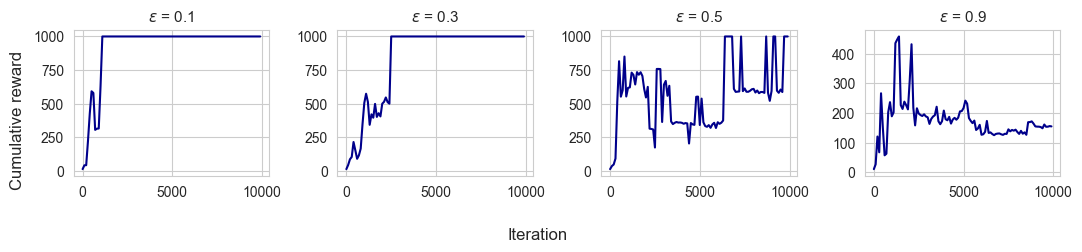

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(11, 2.5), tight_layout=True)

kwarg_list = [
    {"epsilon": 0.1}, 
    {"epsilon": 0.3}, 
    {"epsilon": 0.5},
    {"epsilon": 0.9},
]

for i, ax in enumerate(axes.reshape(-1)):
    kwargs = kwarg_list[i] 
    agent = MCOnPolicyAgent(env, **kwargs)
    reward_hist, step = agent.fit(n_iter=int(1e4), test_freq=0.01)
    iters = [100*i for i in range(100)]
    ax.plot(iters, reward_hist, c="darkblue")
    ax.set_title(f"$\epsilon$ = {kwargs['epsilon']:.1f}", fontsize=11)

fig.supxlabel("Iteration")
fig.supylabel("Cumulative reward")
    
plt.show()
plt.close()

100%|██████████| 10000/10000 [17:11<00:00,  9.69it/s]


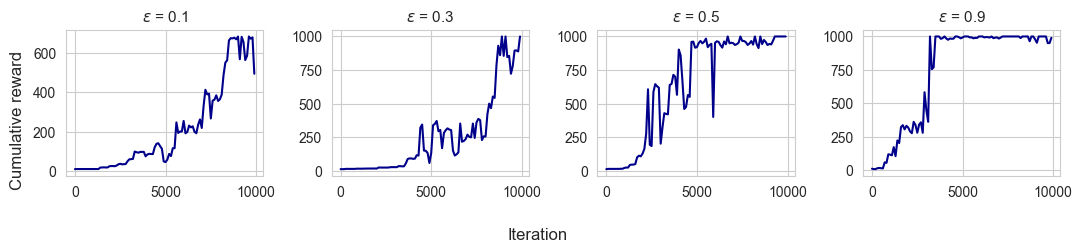

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(11, 2.5), tight_layout=True)

kwarg_list = [
    {"epsilon": 0.1}, 
    {"epsilon": 0.3}, 
    {"epsilon": 0.5},
    {"epsilon": 0.9},
]

for i, ax in enumerate(axes.reshape(-1)):
    kwargs = kwarg_list[i] 
    agent = ExpecetedSARSAAgent(env, **kwargs)
    reward_hist, step = agent.fit(n_iter=int(1e4), test_freq=0.01)
    iters = [100*i for i in range(100)]
    ax.plot(iters, reward_hist, c="darkblue")
    ax.set_title(f"$\epsilon$ = {kwargs['epsilon']:.1f}", fontsize=11)

fig.supxlabel("Iteration")
fig.supylabel("Cumulative reward")
    
plt.show()
plt.close()

100%|██████████| 10000/10000 [06:32<00:00, 25.50it/s]


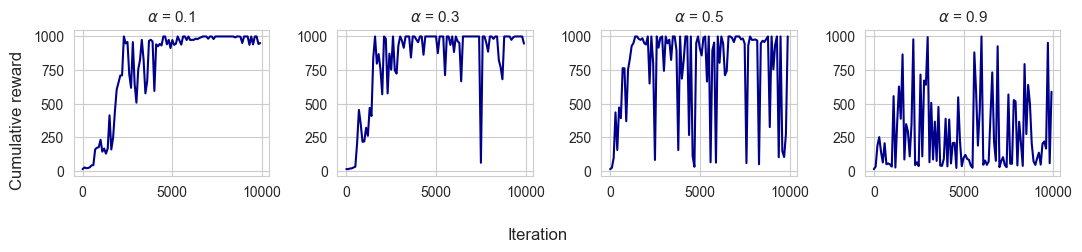

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(11, 2.5), tight_layout=True)

kwarg_list = [
    {"alpha": 0.1}, 
    {"alpha": 0.3}, 
    {"alpha": 0.5},
    {"alpha": 0.9},
]

for i, ax in enumerate(axes.reshape(-1)):
    kwargs = kwarg_list[i] 
    agent = ExpecetedSARSAAgent(env, **kwargs, epsilon=0.5)
    reward_hist, step = agent.fit(n_iter=int(1e4), test_freq=0.01)
    iters = [100*i for i in range(100)]
    ax.plot(iters, reward_hist, c="darkblue")
    ax.set_title(f"$\\alpha$ = {kwargs['alpha']:.1f}", fontsize=11)

fig.supxlabel("Iteration")
fig.supylabel("Cumulative reward")
    
plt.show()
plt.close()

In [9]:
mc_agent = MCOnPolicyAgent(env, 0.3)
mc_hist, _ = mc_agent.fit()

100%|██████████| 10000/10000 [1:07:08<00:00,  2.48it/s]


In [12]:
sarsa_agent = ExpecetedSARSAAgent(env, 0.5, alpha=0.1)
sarsa_hist, _ = sarsa_agent.fit()

100%|██████████| 10000/10000 [49:00<00:00,  3.40it/s] 


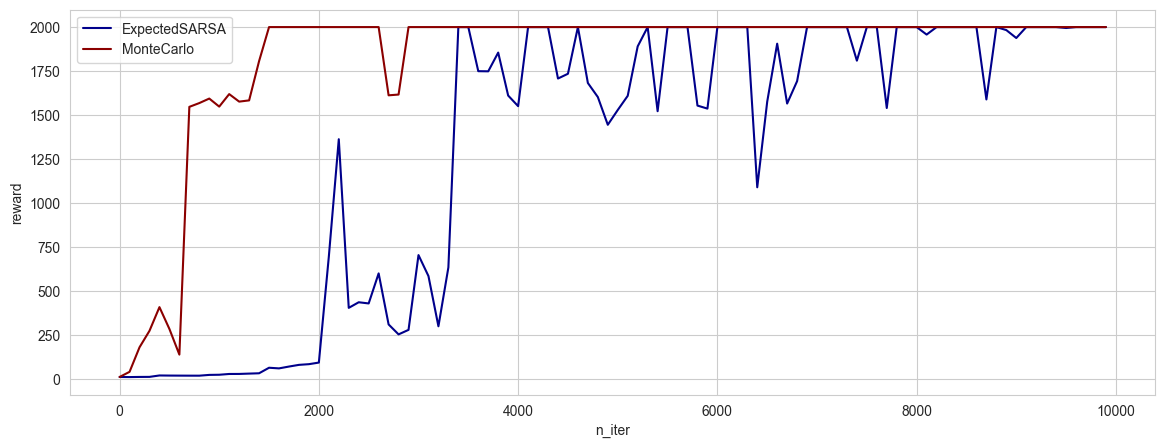

In [13]:
iters = [100*i for i in range(100)]

plt.figure(figsize=(14, 5))
plt.xlabel("n_iter")
plt.ylabel("reward")
plt.plot(iters, sarsa_hist, c="darkblue", label=str(sarsa_agent))
plt.plot(iters, mc_hist, c="darkred", label=str(mc_agent))
plt.legend()
plt.show()
plt.close()

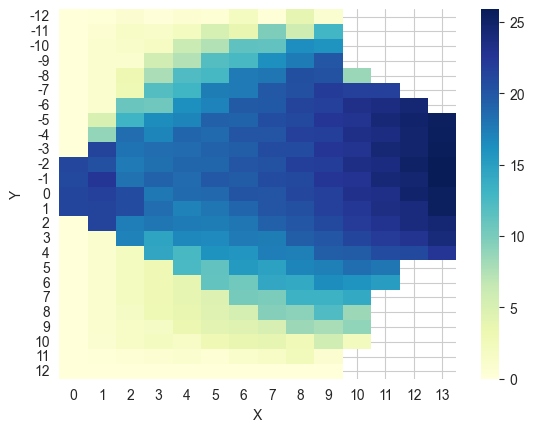

In [14]:
import seaborn as sns

sarsa_Q = sarsa_agent.get_value_function()
sns.heatmap(sarsa_Q, cmap="YlGnBu", mask=sarsa_Q.isnull())
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
plt.close()

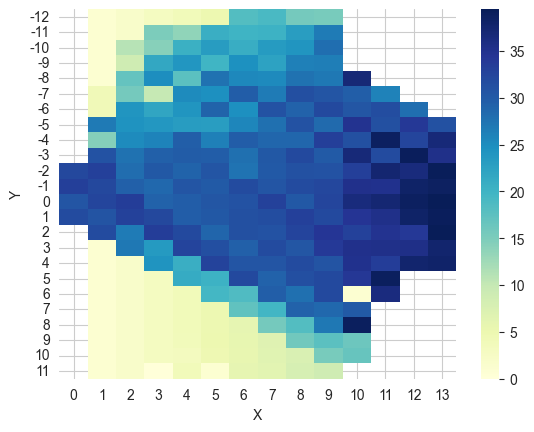

In [15]:
import seaborn as sns

mc_Q = mc_agent.get_value_function()
sns.heatmap(mc_Q, cmap="YlGnBu", mask=mc_Q.isnull())
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
plt.close()

In [5]:
obs, _ = env.reset()

while True:
    action = mc_agent.policy(obs)
    
    obs, reward, done, _, info = env.step(action)

    clear_output(True)
    sys.stdout.write(env.render())
    time.sleep(0.2)


    if done:
        break

Text Flappy Bird!
Score: 10
----------------------
[ |         |        ]
[ |    @    |        ]
[ |         |        ]
[ |                  ]
[ |                  ]
[                    ]
[                    ]
[           |        ]
[           |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=5,dy=-4)
